In [1]:
import requests
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier as KNN_Class
from sklearn.metrics import classification_report as rep
from sklearn.model_selection import GridSearchCV as gscv

import warnings
warnings.simplefilter(action='ignore')

In [2]:
url = "https://raw.githubusercontent.com/joepollastrini/Loan-Prediction/master"
train_name = 'train_loan_data.csv'
test_name = 'test_loan_data.csv'

In [3]:
def data_grab_online(base, name, out='output.csv'):
    #get data from url
    u = base + '/' + name
    r = requests.get(u).content
    df = pd.read_csv(u)
    return df

In [4]:
train = data_grab_online(url, train_name)
test = data_grab_online(url, test_name)

Clean like normal, don't clean anything that mode was used as imputation.  If any feature engineering was used from these imputed variables.  Keep them out until imputed.

In [5]:
def gender_impute_and_dummy(row):
    #if unmarried and 1 dependent female, else male
    if pd.isnull(row['Gender']):
        if row['Married'] == 'No' and row['Dependents'] == '1':
            return 0
        else:
            return 1
    else:
        if row['Gender'] == 'Male':
            return 1
        else:
            return 0
        
train['Male_IO'] = train.apply(lambda x: gender_impute_and_dummy(x), axis=1)
train.drop(columns = ['Gender'], inplace=True)

test['Male_IO'] = test.apply(lambda x: gender_impute_and_dummy(x), axis=1)
test.drop(columns = ['Gender'], inplace = True)

In [6]:
def married_impute_and_dummy(x):
    #if female, not married, otherwise married
    if pd.isnull(x['Married']):
        if x['Male_IO'] == 0:
            return 0
        else:
            return 1
    else:
        if x['Married'] == 'Yes':
            return 1
        else:
            return 0
        
train['Married_IO'] = train.apply(lambda x: married_impute_and_dummy(x), axis=1)
train.drop(columns = ['Married'], inplace=True)

test['Married_IO'] = test.apply(lambda x: married_impute_and_dummy(x), axis=1)
test.drop(columns = ['Married'], inplace = True)

In [7]:
def dependents_impute_and_ordinal(x):
    #if married, one dependent, otherwise none
    #convert dependents to ordinal int as well
    if pd.isnull(x['Dependents']):
        if x['Married_IO'] == 1:
            return 1
        else:
            return 0
    elif x['Dependents'] == '3+':
        return 3
    else:
        return int(x['Dependents'])
    
    
train['Dependents_Ord'] = train.apply(lambda x: dependents_impute_and_ordinal(x), axis=1)
train.drop(columns = ['Dependents'], inplace=True)

test['Dependents_Ord'] = test.apply(lambda x: dependents_impute_and_ordinal(x), axis=1)
test.drop(columns = ['Dependents'], inplace = True)

In [8]:
def dual_income_dummy(x):
    if x['Married_IO'] == 1:
        if x['CoapplicantIncome'] > 0:
            return 1
        else:
            return 0
    else:
        return 0

In [9]:
def clean(df):
    col_drop = []
    col_rename = {}
    
    # FAMILY SIZE #
    df['FamilySize'] = df['Dependents_Ord'] + df['Married_IO'] + 1
        
    # EDUCATION #
    df['Education_IO'] = df['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)
    col_drop.append('Education')

    # INCOME #
    df['FamilyIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['DualIncome_IO'] = df.apply(lambda x: dual_income_dummy(x), axis=1)
    col_drop.extend(['ApplicantIncome', 'CoapplicantIncome'])
    
    # PROPERTY AREA #
    df['PA_Urban'] = df['Property_Area'].apply(lambda x: 1 if x == 'Urban' else 0)
    df['PA_Rural'] = df['Property_Area'].apply(lambda x: 1 if x == 'Rural' else 0)
    df['PA_Semiurban'] = df['Property_Area'].apply(lambda x: 1 if x == 'Semiurban' else 0)
    col_drop.append('Property_Area')
    
    # INCOME PER FAMILY MEMBER #
    df['IncomePerMember'] = df['FamilyIncome'] / df['FamilySize']
    
    #column cleaning
    df.drop(columns = col_drop, inplace=True)
    df.rename(columns=col_rename, inplace=True)
    return df

In [10]:
train_clean = clean(train)
test_clean = clean(test)

In [11]:
nans = train_clean.isna().sum()
nans = nans.loc[nans > 0]
nans

Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

Remove all nan values in order to build model

In [12]:
train_full = train_clean.dropna(subset = ['Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'])
test_full = test_clean.dropna(subset = ['Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'])

Will start with the lowest amount and work up to largest amount

***
## KNN for Loan_Amount_Term

Remove any nan values from any variable used in model.  Create indicators for mode (360) or not.  Create another variable grouping terms.

In [13]:
train_full['Loan_Amount_Term'].unique()

array([360., 120., 180.,  60., 300., 480., 240.,  36.,  84.])

In [14]:
trainLAT = train_full.copy()
testLAT = test_full.copy()

def loan_group(x):
    x = int(x)
    if x == 360:
        return '30'
    elif x == 180:
        return '15'
    elif x < 180:
        return '<15'
    elif x > 180 and x < 360:
        return '(15, 30)'
    elif x > 360:
        return '>30'
    else:
        return '??'
    
def mode_dummy(x):
    x = int(x)
    if x == 360:
        return 1
    else:
        return 0
    
trainLAT['LoanTermGroups'] = trainLAT['Loan_Amount_Term'].apply(lambda x: loan_group(x))
trainLAT['LT_30'] = trainLAT['Loan_Amount_Term'].apply(lambda x: mode_dummy(x))
trainLAT['Self_Employed_IO'] = trainLAT['Self_Employed'].apply(lambda x: 1 if x=='Yes' else 0)

testLAT['LoanTermGroups'] = testLAT['Loan_Amount_Term'].apply(lambda x: loan_group(x))
testLAT['LT_30'] = testLAT['Loan_Amount_Term'].apply(lambda x: mode_dummy(x))
testLAT['Self_Employed_IO'] = testLAT['Self_Employed'].apply(lambda x: 1 if x=='Yes' else 0)

### Method 1:
KNN classifier to predict loan term group

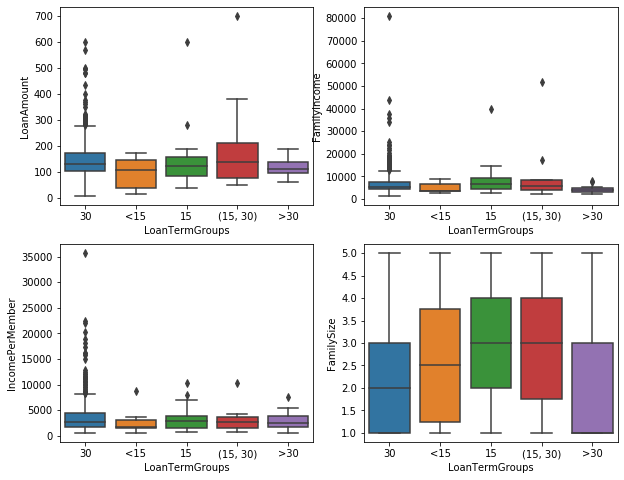

In [15]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
sns.boxplot(trainLAT['LoanTermGroups'], trainLAT['LoanAmount']);

ax2 = fig.add_subplot(2,2,2)
sns.boxplot(trainLAT['LoanTermGroups'], trainLAT['FamilyIncome']);

ax3 = fig.add_subplot(2,2,3)
sns.boxplot(trainLAT['LoanTermGroups'], trainLAT['IncomePerMember']);

ax4 = fig.add_subplot(2,2,4)
sns.boxplot(trainLAT['LoanTermGroups'], trainLAT['FamilySize']);

Use forward selection to try and find the best model

In [38]:
def knn(train, test, x_cols, y, mode):
    x_train = train[x_cols]
    y_train = train[y]
    x_test = test[x_cols]
    y_test = test[y]
    
    #determine best k value
    hyperparameters = dict(n_neighbors = list(range(2,20)))
    knn_cv = KNN_Class()
    models = gscv(knn_cv, hyperparameters, cv=5)
    best_model = models.fit(x_train, y_train)
    k = best_model.best_estimator_.get_params()['n_neighbors']
    print('Optimized K:  {}'.format(k))
    
    #fit model
    model = KNN_Class(n_neighbors = k)
    model.fit(x_train, y_train)
    
    ### training set ###
    print(' *** Training ***')
    trainPreds = model.predict(x_train)
    trainPredictions = pd.DataFrame(trainPreds, columns = ['Predicted'])
    print(trainPredictions['Predicted'].value_counts())
    y_train.reset_index(drop=True, inplace=True)
    trainPredictions.reset_index(drop=True, inplace=True)
    trainAccDF = pd.concat((y_train, trainPredictions), axis=1)
    trainAccDF['Right'] = trainAccDF.apply(lambda x: 1 if x[y] == x['Predicted'] else 0, axis=1)
    trainAcc = trainAccDF['Right'].sum() / len(trainAccDF)
    print('\nTraining Accuracy:  {:.2f}%'.format(trainAcc * 100.0))
    
    trainBench = len(trainAccDF.loc[trainAccDF[y] == mode]) / len(trainAccDF)
    print('\n', 'Accuracy if selected mode ({}):  {:.2f}%'.format(mode, trainBench * 100.0))
    ### training set ###
    
    print('\n---------------------------------------------------\n')
    
    ### testing set ###
    print(' *** Testing *** ')
    testPreds = model.predict(x_test)
    testPredictions = pd.DataFrame(testPreds, columns=['Predicted'])
    print(testPredictions['Predicted'].value_counts())
    y_test.reset_index(drop=True, inplace=True)
    testPredictions.reset_index(drop=True, inplace=True)
    testAccDF = pd.concat((y_test, testPredictions), axis=1)
    testAccDF['Right'] = testAccDF.apply(lambda x: 1 if x[y] == x['Predicted'] else 0, axis=1)
    testAcc = testAccDF['Right'].sum() / len(testAccDF)
    print('Testing Accuracy:  {:.2f}%'.format(testAcc * 100.0))
    
    testBench = len(testAccDF.loc[testAccDF[y] == mode]) / len(testAccDF)
    
    print('\n', 'Accuracy if selected mode ({}):  {:.2f}%'.format(mode, testBench * 100.0))
    ### testing set ###
    
    return model

In [17]:
knn(trainLAT, testLAT, ['LoanAmount'], 'LoanTermGroups', '30')

Optimized K:  8
 *** Training ***
30    504
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    306
Name: Predicted, dtype: int64
Testing Accuracy:  85.62%

 Accuracy if selected mode (30):  85.62%


In [18]:
knn(trainLAT, testLAT, ['FamilyIncome'], 'LoanTermGroups', '30')

Optimized K:  7
 *** Training ***
30    504
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    306
Name: Predicted, dtype: int64
Testing Accuracy:  85.62%

 Accuracy if selected mode (30):  85.62%


In [19]:
knn(trainLAT, testLAT, ['IncomePerMember'], 'LoanTermGroups', '30')

Optimized K:  10
 *** Training ***
30    504
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    306
Name: Predicted, dtype: int64
Testing Accuracy:  85.62%

 Accuracy if selected mode (30):  85.62%


In [20]:
knn(trainLAT, testLAT, ['FamilySize'], 'LoanTermGroups', '30')

Optimized K:  4
 *** Training ***
30    504
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    306
Name: Predicted, dtype: int64
Testing Accuracy:  85.62%

 Accuracy if selected mode (30):  85.62%


Will start with IncomePerMember and look to improve on accuracy

In [21]:
knn(trainLAT, testLAT, ['IncomePerMember'], 'LoanTermGroups', '30')

Optimized K:  10
 *** Training ***
30    504
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    306
Name: Predicted, dtype: int64
Testing Accuracy:  85.62%

 Accuracy if selected mode (30):  85.62%


In [22]:
knn(trainLAT, testLAT, ['IncomePerMember', 'FamilyIncome'], 'LoanTermGroups', '30')

Optimized K:  7
 *** Training ***
30    503
15      1
Name: Predicted, dtype: int64

Training Accuracy:  85.52%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    305
15      1
Name: Predicted, dtype: int64
Testing Accuracy:  85.95%

 Accuracy if selected mode (30):  85.62%


In [23]:
knn(trainLAT, testLAT, ['FamilySize', 'IncomePerMember'], 'LoanTermGroups', '30')

Optimized K:  10
 *** Training ***
30    504
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    306
Name: Predicted, dtype: int64
Testing Accuracy:  85.62%

 Accuracy if selected mode (30):  85.62%


In [24]:
knn(trainLAT, testLAT, ['LoanAmount', 'IncomePerMember'], 'LoanTermGroups', '30')

Optimized K:  10
 *** Training ***
30    502
15      2
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    305
15      1
Name: Predicted, dtype: int64
Testing Accuracy:  85.29%

 Accuracy if selected mode (30):  85.62%


Tried using indicator vars, everything was exact same accuracy, and worse than above models

In [25]:
knn(trainLAT, testLAT, ['LoanAmount', 'IncomePerMember', 'PA_Urban', 'PA_Semiurban'], 'LoanTermGroups', '30')

Optimized K:  10
 *** Training ***
30    502
15      2
Name: Predicted, dtype: int64

Training Accuracy:  85.32%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    305
15      1
Name: Predicted, dtype: int64
Testing Accuracy:  85.29%

 Accuracy if selected mode (30):  85.62%


Use the below model (IncomePerMember and FamilyIncome to impute loan term (grouping) with K=7.  This model improves on the accuracy of only selecting the mode (30 year term) for both test and train set. It still mostly selects 30 year, but is correct when selecting a different term.

In [39]:
m = knn(trainLAT, testLAT, ['IncomePerMember', 'FamilyIncome'], 'LoanTermGroups', '30')

Optimized K:  7
 *** Training ***
30    503
15      1
Name: Predicted, dtype: int64

Training Accuracy:  85.52%

 Accuracy if selected mode (30):  85.32%

---------------------------------------------------

 *** Testing *** 
30    305
15      1
Name: Predicted, dtype: int64
Testing Accuracy:  85.95%

 Accuracy if selected mode (30):  85.62%


In [27]:
os.getcwd()

'C:\\Users\\joepo\\Desktop\\Project Portfolio\\Loan Prediction\\Credit History'

In [30]:
os.chdir('..')

In [32]:
x = os.getcwd()

In [33]:
os.path.join(x, 'Models')

'C:\\Users\\joepo\\Desktop\\Project Portfolio\\Loan Prediction\\Models'

In [34]:
import pickle

In [35]:
fname = 'knn_Loan_Term.sav'

In [40]:
pickle.dump(m, open(os.path.join(x, 'Models', fname), 'wb'))